
# Demo: Generic Supervised Machine Learning Pipeline



### set up environment

In [24]:
# import modules and classes

import os, sys, shutil, getpass
import pprint, logging, datetime
import stat

import numpy   as np
import pandas  as pd
import seaborn as sns

In [79]:
# define path of jupyter notebook, and code and data directories relative to it

dir_MASTER = ".."
dir_code   = os.path.join(dir_MASTER, "code")
dir_data   = os.path.join(dir_MASTER, "data")

In [81]:
# check dir_code has been set correctly

print(os.listdir(dir_code))

['__init__.py', '__pycache__', 'examineData.py', 'PipelinePreprocessHousingData.py', 'splitTrainTest.py', 'trainEvaluate.py', 'trainEvaluateGrid.py', 'visualizeData.py']


In [34]:
# append code directory to list of library paths (to enable use of Python modules therein)

sys.path.append(dir_code)


## California "census block group" housing data

In [83]:
# load California housing

housingFILE = os.path.join(dir_data,'housing.csv')
housingDF   = pd.read_csv(housingFILE);

In [84]:
# view first several rows of housingDF

housingDF.info()
housingDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


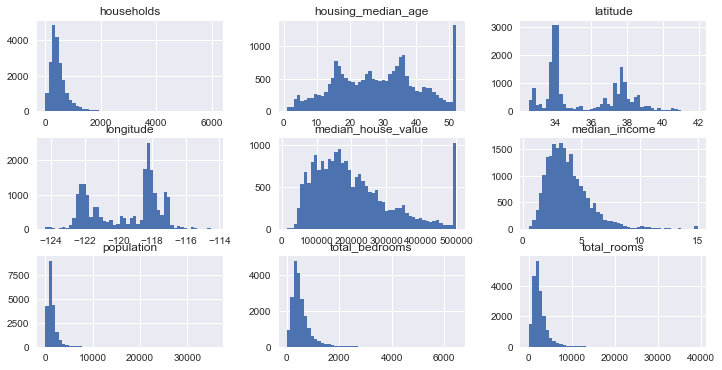

In [26]:
import matplotlib.pyplot as plt
myHistogram = housingDF.hist(bins = 50, figsize = (12,6))
plt.show()


## Split data into training and testing sets

In [31]:
# define the splitTrainTest() function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import importlib
from   importlib.util import find_spec
ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
if ms_spec is not None:
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import train_test_split

def splitTrainTest(inputDF,random_state):

    ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
    if ms_spec is None:
        trainSet, testSet = train_test_split(inputDF, test_size=0.2, random_state=random_state)
    else:
        inputDF["income_category"] = np.ceil(inputDF["median_income"]/1.5)
        inputDF["income_category"].where( inputDF["income_category"] < 5.0 , 5.0, inplace = True )

        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=19)
        for trainIndices, testIndices in split.split(inputDF,inputDF["income_category"]):
            trainSet = inputDF.loc[trainIndices]
            testSet  = inputDF.loc[testIndices]

        for set in (trainSet,testSet):
            set.drop(["income_category"],axis=1,inplace=True)

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    return( trainSet , testSet )

In [32]:
# split into training and testing data sets in a stratified manner

trainSet, testSet = splitTrainTest(inputDF = housingDF, random_state = 19)

In [60]:
print(housingDF.shape)
print(trainSet.shape)
print(testSet.shape)

(20640, 11)
(16512, 10)
(4128, 10)


In [63]:
housingDF.info()
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
income_category       20640 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 8663 to 7054
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16336 non-null float64
populati

In [64]:
# Preprocessing:
#   1)  median imputation for continuous variables
#   2)  add two derived variables: number of rooms per household, population per household
#   3)  binarize the categorical variable: ocean_proximity (replace it with a collection of binary indicators)

from PipelinePreprocessHousingData import PipelinePreprocessHousingData
preprocessedTrainSet = PipelinePreprocessHousingData.fit_transform(
    trainSet.drop(["median_house_value"],axis=1)
    )

In [52]:
print(type(preprocessedTrainSet))
preprocessedTrainSet[0:3,]

<class 'numpy.ndarray'>


array([[ 0.59311284, -0.84368509,  0.91777934,  0.19522684,  0.07694854,
        -0.14480532,  0.01372209,  0.68219324,  0.27712397, -0.09712907,
        -0.42595431,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.09212684, -1.13781385, -0.91562623, -0.35121612,  0.10330353,
        -0.12355599, -0.19581394, -1.01636674, -0.44156162,  0.00596612,
         1.46978359,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.29173244, -1.35257454, -0.91562623,  0.59509667,  0.73103156,
         0.5024137 ,  0.6947142 , -0.61817454, -0.12078124, -0.0762501 ,
         0.0045411 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [69]:
from sklearn.metrics import mean_squared_error

# import cross_val_score
import importlib
from   importlib.util import find_spec
ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
if ms_spec is not None:
    from sklearn.model_selection import cross_val_score
else:
    from sklearn.cross_validation import cross_val_score

# define the trainEvaluate() function
def trainEvaluate(trainData, testData, trainedPreprocessor, myModel, modelName):

    preprocessedTrainData = trainedPreprocessor.transform(
        trainData.drop(["median_house_value"],axis=1)
        )

    myModel.fit(X = preprocessedTrainData, y = trainData["median_house_value"])
    myPredictions = myModel.predict(X = preprocessedTrainData)

    myTrainMSE  = mean_squared_error(myPredictions,trainData["median_house_value"])
    myTrainRMSE = np.sqrt(myTrainMSE)

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    nFold =10

    CVScores = cross_val_score(
        estimator = myModel,
        X         = preprocessedTrainData,
        y         = trainData["median_house_value"],
        scoring   = "neg_mean_squared_error",
        cv        = nFold
        )
    CVRMSE = np.sqrt( - CVScores )

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    preprocessedTestData = trainedPreprocessor.transform(
        testData.drop(["median_house_value"],axis=1)
        )

    myPredictions = myModel.predict(X = preprocessedTestData)

    myTestMSE  = mean_squared_error(myPredictions,testData["median_house_value"])
    myTestRMSE = np.sqrt(myTestMSE)

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    print("\n### ~~~~~~~~~~~~~~~~~~~~ ###")
    print("###  " + modelName)

    print("\nTrain RMSE: " + str(myTrainRMSE))

    print("\nCV RMSE (" + str(nFold) + "-fold):")
    print(CVRMSE)
    print("\nCV RMSE (mean): " + str(CVRMSE.mean()) )
    print("\nCV RMSE (std): "  + str(CVRMSE.std())  )

    print("\nTest RMSE: " + str(myTestRMSE))

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    return( None )


In [70]:
# linear model (this underfits the data)

from sklearn.linear_model import LinearRegression
myLinearModel = LinearRegression()
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myLinearModel,
    modelName           = "Linear Model"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Linear Model

Train RMSE: 68205.5245154

CV RMSE (10-fold):
[ 71213.42875203  69374.24757249  69744.15111082  67634.72605826
  67556.95118003  70447.0948898   66602.78109188  67053.6825131
  69152.900413    68090.74548673]

CV RMSE (mean): 68687.0709068

CV RMSE (std): 1450.490324

Test RMSE: 68763.2267712


In [71]:
# regression tree (this overfits the data: zero MSE)

from sklearn.tree import DecisionTreeRegressor
myRegressionTreeModel = DecisionTreeRegressor()
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myRegressionTreeModel,
    modelName           = "Regression Tree"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Regression Tree

Train RMSE: 0.0

CV RMSE (10-fold):
[ 70644.98404346  70694.11007518  69971.89205113  70833.24897125
  67842.34087961  72158.39900427  71707.67082508  73172.99317222
  66442.32590114  67110.76536155]

CV RMSE (mean): 70057.8730285

CV RMSE (std): 2118.07272048

Test RMSE: 71327.5036917


In [72]:
# random forest

from sklearn.ensemble import RandomForestRegressor
myRandomForestModel = RandomForestRegressor()
trainEvaluate(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = myRandomForestModel,
    modelName           = "Random Forest"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Random Forest

Train RMSE: 22130.758657

CV RMSE (10-fold):
[ 53355.99264213  54279.63024356  54824.01559291  51615.89475211
  52062.01916125  54817.82552528  52848.43234377  51478.13817967
  48414.87243771  54038.64176538]

CV RMSE (mean): 52773.5462644

CV RMSE (std): 1874.02393064

Test RMSE: 51481.189213


In [73]:
from sklearn.metrics         import mean_squared_error
from sklearn.preprocessing   import LabelEncoder

def trainEvaluateGrid(trainData, testData, trainedPreprocessor, myModel, modelName):

    preprocessedTrainData = trainedPreprocessor.transform(
        trainData.drop(["median_house_value"],axis=1)
        )

    myModel.fit(X = preprocessedTrainData, y = trainData["median_house_value"])
    myPredictions = myModel.predict(X = preprocessedTrainData)

    myTrainMSE  = mean_squared_error(myPredictions,trainData["median_house_value"])
    myTrainRMSE = np.sqrt(myTrainMSE)

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    preprocessedTestData = trainedPreprocessor.transform(
        testData.drop(["median_house_value"],axis=1)
        )

    myPredictions = myModel.predict(X = preprocessedTestData)

    myTestMSE  = mean_squared_error(myPredictions,testData["median_house_value"])
    myTestRMSE = np.sqrt(myTestMSE)

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    print("\n### ~~~~~~~~~~~~~~~~~~~~ ###")
    print("###  " + modelName)

    print("\nTrain RMSE: " + str(myTrainRMSE))

    print("\n(Cross Validation, Grid Search) RSME:")
    CVResults = myModel.cv_results_
    for mean_score, params in zip(CVResults["mean_test_score"], CVResults["params"]):
        print( np.sqrt(-mean_score) , params )

    print("\nbest_params_:")
    print(   myModel.best_params_ )

    print("\ngridSearch.best_estimator_")
    print(   myModel.best_estimator_ )

    print("\nTest RMSE: " + str(myTestRMSE))

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    # examine feature importances
    featureImportances = myModel.best_estimator_.feature_importances_

    numericAttribs = list(trainData.drop(["ocean_proximity"],axis=1).columns)

    oneHotEncoder     = LabelEncoder()
    housingCatEncoded = oneHotEncoder.fit(trainData["ocean_proximity"])
    oneHotAttribs     = oneHotEncoder.classes_

    extraAttribs = ["roomsPerHhold", "popPerHhold", "bedroomsPerRoom"]
    attributes = list(numericAttribs) + extraAttribs + list(oneHotAttribs)

    print("\nfeatureImportances")
    for currentItem in sorted(zip(featureImportances,attributes),reverse=True):
        print( currentItem )

    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    return( None )


In [74]:
# random forest with hyperparameter tuning via grid search

from sklearn.ensemble import RandomForestRegressor

ms_spec = importlib.util.find_spec(name="sklearn.model_selection")
if ms_spec is not None:
    from sklearn.model_selection import GridSearchCV
else:
    from sklearn.grid_search import GridSearchCV

# instantiate random forest regressor
newRandomForestModel = RandomForestRegressor()

parameterGrid = [
    { 'n_estimators':[3,10,30], 'max_features':[2,4,6,8]                     },
    { 'n_estimators':[3,10],    'max_features':[2,3,4],  'bootstrap':[False] }
    ]

gridSearch = GridSearchCV(
    estimator  = newRandomForestModel,
    param_grid = parameterGrid,
    scoring    = "neg_mean_squared_error",
    cv         = 5
    )

trainEvaluateGrid(
    trainData           = trainSet,
    testData            = testSet,
    trainedPreprocessor = PipelinePreprocessHousingData,
    myModel             = gridSearch,
    modelName           = "Random Forest, Cross Validation, Grid Search"
    )


### ~~~~~~~~~~~~~~~~~~~~ ###
###  Random Forest, Cross Validation, Grid Search

Train RMSE: 19280.5129358

(Cross Validation, Grid Search) RSME:
63584.9710079 {'max_features': 2, 'n_estimators': 3}
54743.8396444 {'max_features': 2, 'n_estimators': 10}
52535.6682863 {'max_features': 2, 'n_estimators': 30}
60203.2624353 {'max_features': 4, 'n_estimators': 3}
52253.4741608 {'max_features': 4, 'n_estimators': 10}
50450.0932575 {'max_features': 4, 'n_estimators': 30}
59786.4028529 {'max_features': 6, 'n_estimators': 3}
52003.9383904 {'max_features': 6, 'n_estimators': 10}
50117.0632746 {'max_features': 6, 'n_estimators': 30}
58985.8164306 {'max_features': 8, 'n_estimators': 3}
52242.4758582 {'max_features': 8, 'n_estimators': 10}
50176.4968498 {'max_features': 8, 'n_estimators': 30}
61618.4144226 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53971.85323 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60328.0851852 {'bootstrap': False, 'max_features': 3, 'n_estimato